<a href="https://colab.research.google.com/github/jessicanadalete/health_insurance_cross_sell/blob/main/health_insurance_cross_sell.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##0.0 Imports

In [ ]:
pip install inflection

In [ ]:
!pip install scipy==1.9.3
!pip install scikit-plot


  Using cached scikit_plot-0.3.7-py3-none-any.whl.metadata (7.1 kB)
Using cached scikit_plot-0.3.7-py3-none-any.whl (33 kB)


In [ ]:
import pickle
import numpy              as np
import pandas             as pd
import seaborn            as sns
import scikitplot         as skplt
import matplotlib.pyplot  as plt
import inflection

from sklearn                import preprocessing as pp
from sklearn.neighbors      import KNeighborsClassifier
from sklearn                import model_selection as ms
from sklearn                import ensemble as en
from sklearn                import linear_model as lm


##0.1 Loading dataset

In [ ]:
df_raw = pd.read_csv('train.csv', low_memory=False)

## 1.0 Data Description

In [ ]:
#creating a copy of data
df1 = df_raw.copy()

In [ ]:
df1.columns

Index(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')

In [ ]:
old_columns = ['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
               'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
               'Policy_Sales_Channel', 'Vintage', 'Response']

snakecase = lambda x: inflection.underscore(x)
new_columns = list(map(snakecase, old_columns))

df1.columns = new_columns

## 1.1 Data Dimension

In [ ]:
df1.shape

(381109, 12)

## 1.2 Data Types

In [ ]:
df1.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [ ]:
df1.dtypes

,0
id,int64
gender,object
age,int64
driving_license,int64
region_code,float64
previously_insured,int64
vehicle_age,object
vehicle_damage,object
annual_premium,float64
policy_sales_channel,float64


In [ ]:
df1['vehicle_age'].unique()

array(['> 2 Years', '1-2 Year', '< 1 Year'], dtype=object)

In [ ]:
df1.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


## 1.3 Check NAs

In [ ]:
#checking the sum of NA in each column
df1.isna().sum()

,0
id,0
gender,0
age,0
driving_license,0
region_code,0
previously_insured,0
vehicle_age,0
vehicle_damage,0
annual_premium,0
policy_sales_channel,0


3.4 Descriptive Statistical

In [ ]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64'])

In [ ]:
#central tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T #range
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,9.443274e-16,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
3,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
4,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
5,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
6,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
7,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


#2.0 Feature Engineering

In [ ]:
df2 = df1.copy()

# 3.0 Data Filtering

In [ ]:
df3 = df2.copy()

#4.0 Exploraotry Data Analysis

In [ ]:
df4 = df3.copy()

### 4.1 Univariate Analysis

#####Analysing variables x reponse

In [ ]:
#gender
pd.crosstab(df4['gender'], df4['response']).apply (lambda x: x/x.sum().sum())


response,0,1
gender,,
Female,0.469006,0.389317
Male,0.530994,0.610683


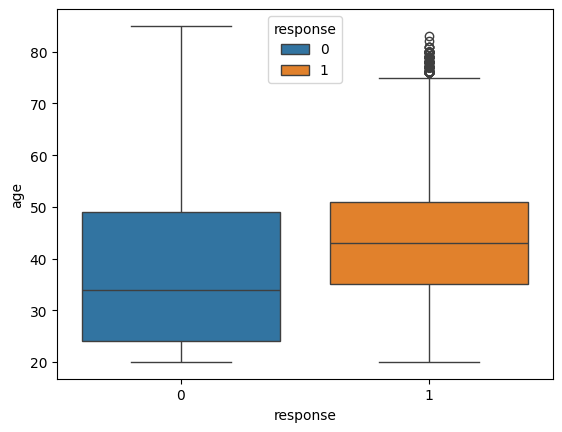

In [ ]:
#age

sns.boxplot(x='response', y='age', hue = 'response', data = df4);

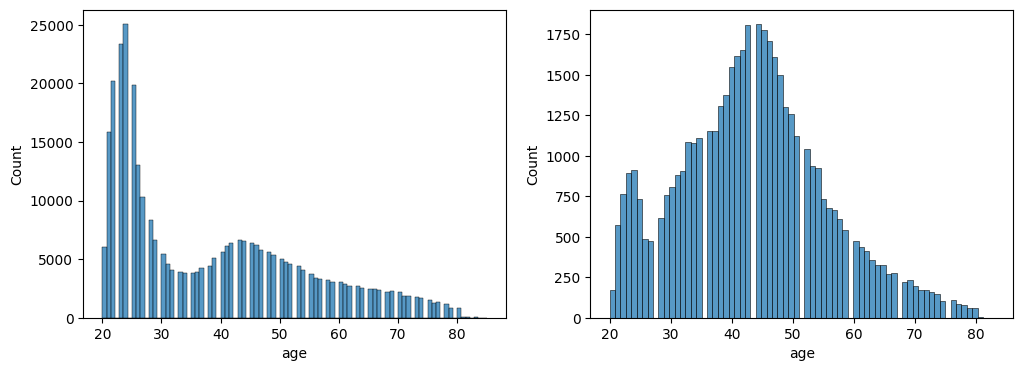

In [ ]:
#understanding age distribuition
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

aux1 = df4.loc[df4['response'] == 0, 'age']
sns.histplot(aux1, ax=axes[0]);

aux2 = df4.loc[df4['response'] == 1, 'age']
sns.histplot(aux2, ax=axes[1]);

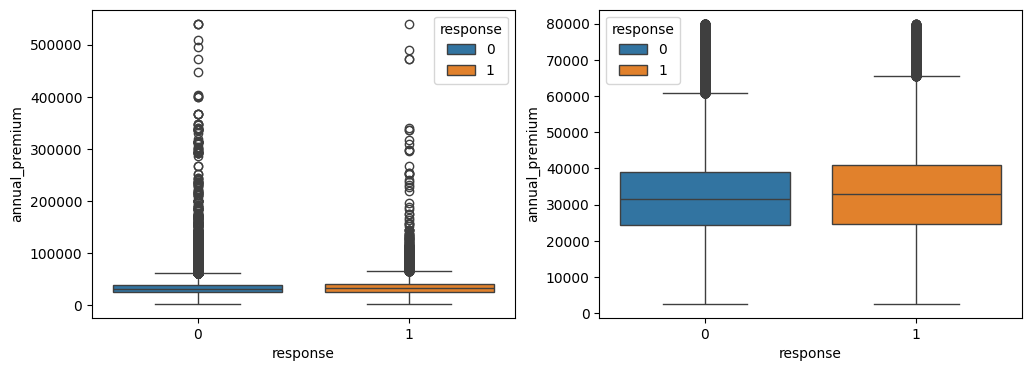

In [ ]:
#annual premium
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.boxplot(x='response', y='annual_premium', hue = 'response', data = df4, ax=axes[0]);

#filtering the annual premium variable to visualize better
aux1 = df4[df4['annual_premium'] < 80000]
sns.boxplot(x='response', y='annual_premium', hue = 'response', data = aux1, ax=axes[1]);

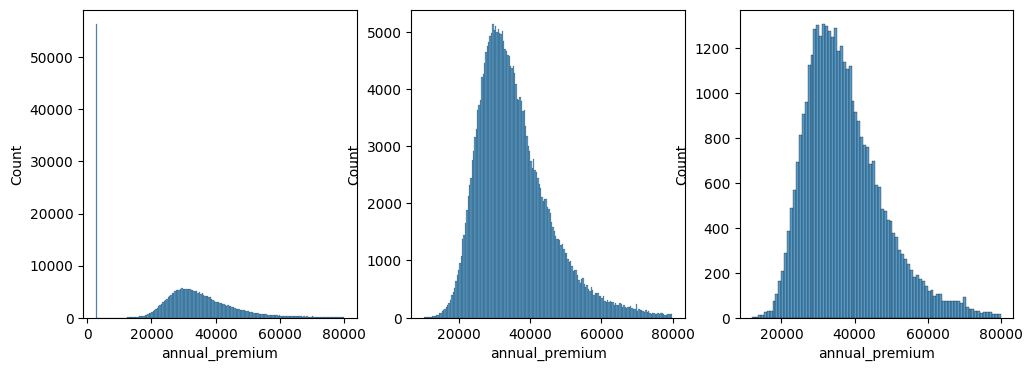

In [ ]:
#annual premium
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

aux2 = aux1.loc[aux1['response'] == 0, 'annual_premium']
sns.histplot(aux2, ax=axes[0]);

aux4 = df4[(df4['annual_premium'] > 10000) & (df4['annual_premium'] < 80000)]
aux3 = aux4.loc[aux4['response'] == 0, 'annual_premium']
sns.histplot(aux3, ax=axes[1]);

aux3 = aux4.loc[aux4['response'] == 1, 'annual_premium']
sns.histplot(aux3, ax=axes[2]);

In [ ]:
#driving license
aux = df4[['driving_license', 'response']].groupby('response').sum().reset_index()
aux['percentage'] = aux['driving_license']/aux['driving_license'].sum()
aux

,response,driving_license,percentage
0,0,333628,0.877283
1,1,46669,0.122717


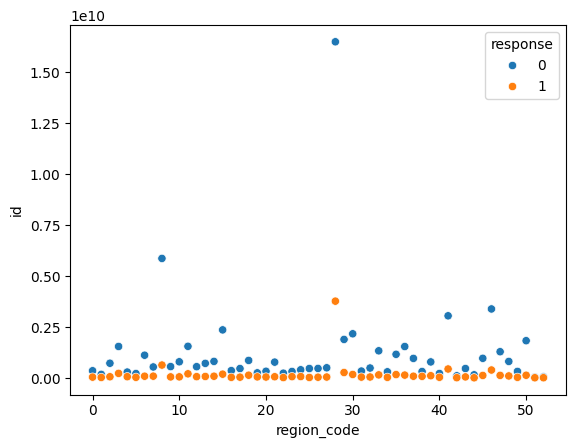

In [ ]:
#region
aux0 = df4[['id','region_code', 'response']].groupby(['region_code','response']).sum().reset_index()
sns.scatterplot(x='region_code', y='id', hue='response', data=aux0);

In [ ]:
#previously_insured insured
aux = df4[['previously_insured', 'response']].groupby('response').sum().reset_index()
aux['percentage'] = aux['previously_insured']/aux['previously_insured'].sum()
aux

,response,previously_insured,percentage
0,0,174470,0.999095
1,1,158,0.000905


In [ ]:
pd.crosstab(df4['previously_insured'], df4['response']).apply (lambda x: x/x.sum(), axis=1)

response,0,1
previously_insured,,
0,0.774546,0.225454
1,0.999095,0.000905


In [ ]:
#vehicle_age

pd.crosstab(df4['vehicle_age'], df4['response']).apply (lambda x: x/x.sum().sum())

response,0,1
vehicle_age,,
1-2 Year,0.494948,0.745151
< 1 Year,0.471245,0.154185
> 2 Years,0.033807,0.100664


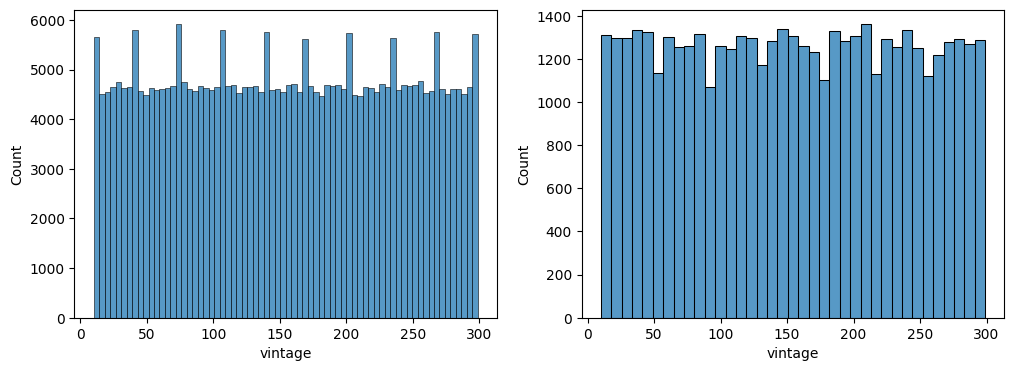

In [ ]:
#vintage

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

aux00 = df4.loc[df4['response'] == 0, 'vintage']
sns.histplot(aux00, ax=axes[0]);

aux11 = df4.loc[df4['response'] == 1, 'vintage']
sns.histplot(aux11, ax=axes[1]);


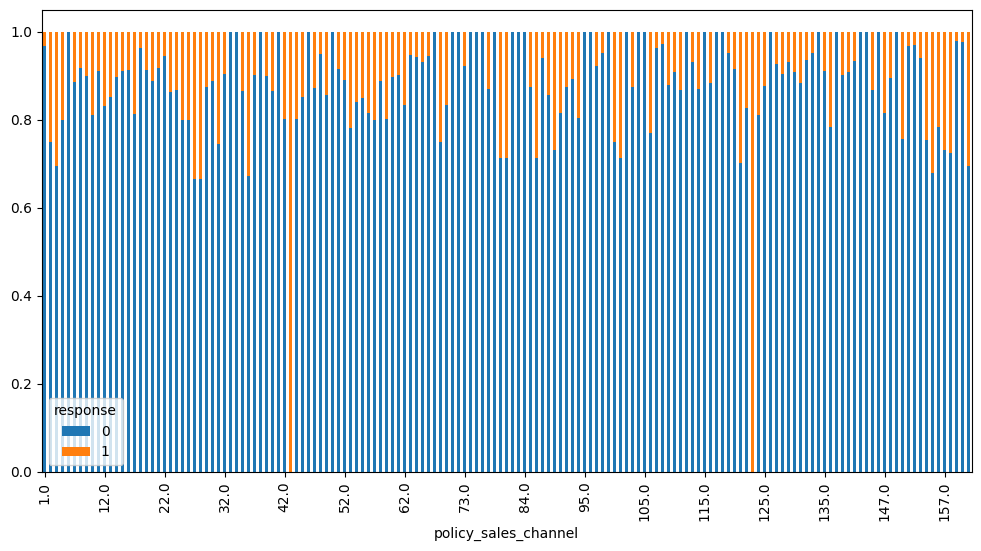

In [ ]:
#policy channel sales

aux= pd.crosstab(df4['policy_sales_channel'], df4['response']).apply(lambda x: x/x.sum(), axis=1)
#aux
ax = aux.plot(kind='bar', stacked=True, figsize=(12,6));
ax.set_xticks(range(0, len(aux), 10));


#5.0 Data Preparation

In [ ]:
df5 = df4.copy()

In [ ]:
x = df4.drop('response', axis=1)
y = df4['response'].copy()

X_train, X_test_, y_train, y_test = ms.train_test_split(x, y, test_size=0.20)

df5 = pd.concat([X_train, y_train], axis=1)

##5.1 Standardization

In [ ]:
#annual premium

stand_annual_premium = pp.StandardScaler()
df5['annual_premium'] = stand_annual_premium.fit_transform(df5[['annual_premium']].values) #cathing only the values

with open('annual_premium.pkl', 'wb') as file:
    pickle.dump(stand_annual_premium, file)

##5.2 Rescaling

In [ ]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

#age
df5['age'] = mms_age.fit_transform(df5[['age']].values)
with open('age.pkl', 'wb') as file:
    pickle.dump(mms_age, file)

#vintage
df5['vintage'] = mms_vintage.fit_transform(df5[['vintage']].values)
with open('vintage.pkl', 'wb') as file:
    pickle.dump(mms_vintage, file)

##5.3 Encoder

In [ ]:
#vehicle damage (Label encoding)

df5['vehicle_damage'] = df5['vehicle_damage'].apply(lambda x: 1 if x == "Yes" else 0)

#gender (Label encoding)

mean_encoded_gender = df5.groupby('gender')['response'].mean()
df5['gender'] = df5['gender'].map(mean_encoded_gender)

#vehicle age transformation (Order encoding)

df5['vehicle_age'] = df5['vehicle_age'].apply(lambda x: 0 if x == "< 1 Year" else 1 if x== "1-2 Year" else 2)

#region_code (Targeting encoding - multivariables)

mean_encoded_region = df5.groupby('region_code')['response'].mean()
df5['region_code'] = df5['region_code'].map(mean_encoded_region)

#previously insurance (Label encoding)

df5['previously_insured'] = df5['previously_insured'].apply(lambda x: 1 if x == "Yes" else 0)

#policy sales channel (Targeting encoding - multivariables)

mean_encoded_channel = df5.groupby('policy_sales_channel').size()/len(df5)
df5['policy_sales_channel'] = df5['policy_sales_channel'].map(mean_encoded_channel)

In [ ]:
df5.isna().sum()

,0
id,0
gender,0
age,0
driving_license,0
region_code,0
previously_insured,0
vehicle_age,0
vehicle_damage,0
annual_premium,0
policy_sales_channel,0


##5.4 Validation Preparation

In [ ]:
#appyling the encoder on test data

X_test_['annual_premium'] = stand_annual_premium.fit_transform(X_test_[['annual_premium']].values)
X_test_['age'] = mms_age.fit_transform(X_test_[['age']].values)
X_test_['vintage'] = mms_vintage.fit_transform(X_test_[['vintage']].values)
X_test_['vehicle_damage'] = X_test_['vehicle_damage'].apply(lambda x: 1 if x == "Yes" else 0)
X_test_['gender'] = X_test_['gender'].map(mean_encoded_gender)
X_test_['vehicle_age'] = X_test_['vehicle_age'].apply(lambda x: 0 if x == "< 1 Year" else 1 if x== "1-2 Year" else 2)
X_test_['region_code'] = X_test_['region_code'].map(mean_encoded_region)
X_test_['previously_insured'] = X_test_['previously_insured'].apply(lambda x: 1 if x == "Yes" else 0)
X_test_['policy_sales_channel'] = X_test_['policy_sales_channel'].map(mean_encoded_channel)

X_test_ = X_test_.fillna(0)

#6.0 Feature Selection

In [ ]:
df6 = df5.copy()

NameError: name 'df5' is not defined

##6.1 Features Importancy

In [ ]:
# model definition
#et_classifier = en.ExtraTreesClassifier(n_estimators=250, random_state=0, n_jobs=-1)

# #data preparation
# x_train_s = df6.drop(['id','response'], axis=1)
# y_train_s = y_train.values

# et_classifier.fit(x_train_s, y_train_s)

In [ ]:
# importances = et_classifier.feature_importances_
# features = x_train_s.columns

# data = pd.DataFrame({
#     'feature': features,
#     'importance': importances
# })

# # Sort the DataFrame by importance
# data = data.sort_values('importance', ascending=False)
# print(data)

#7.0 Machine Learning

In [ ]:
cols_selected = ['vintage','annual_premium','age', 'vehicle_damage', 'region_code', 'policy_sales_channel', 'vehicle_age']
X_train = df6[cols_selected]
X_test = X_test_[cols_selected]

##7.1 KNN Model

In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=7)
knn_model.fit(X_train, y_train)

y_hat = knn_model.predict_proba(X_test)

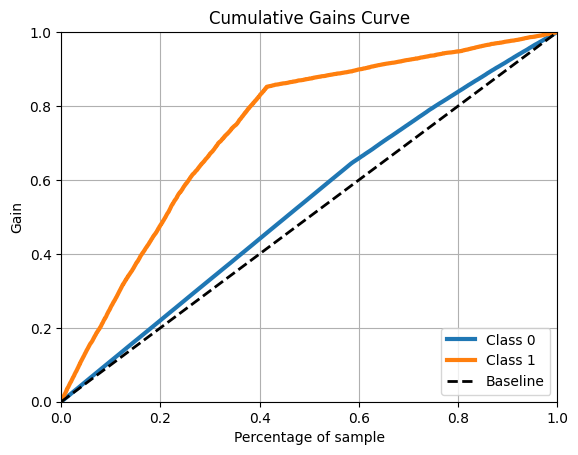

In [ ]:
#Accumulated gain

skplt.metrics.plot_cumulative_gain (y_test, y_hat);

##7.2 Linear Model

In [ ]:
linear_model = lm.LogisticRegression(random_state=42)
linear_model.fit(X_train, y_train)

y_hat_lr = linear_model.predict_proba(X_test)

In [ ]:
with open('linear_model.pkl', 'wb') as file:
    pickle.dump(linear_model, file)

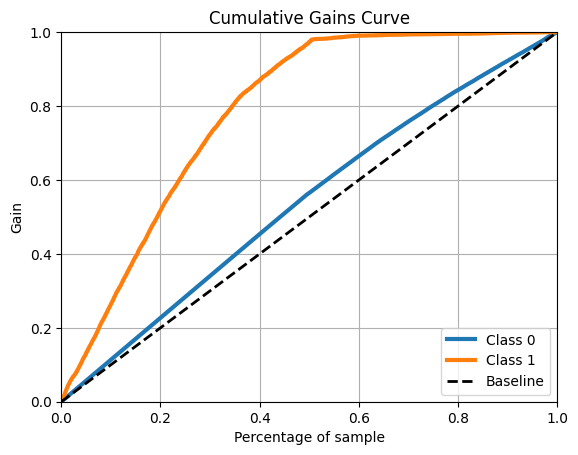

In [ ]:
#Accumulated gain

skplt.metrics.plot_cumulative_gain (y_test, y_hat_lr);

##7.3 Extra Trees

In [ ]:
# model definition
et_classifier = en.ExtraTreesClassifier(n_estimators=100, random_state=42, n_jobs=-1)

#training
et_classifier.fit(X_train, y_train)

y_hat_et = et_classifier.predict_proba(X_test)

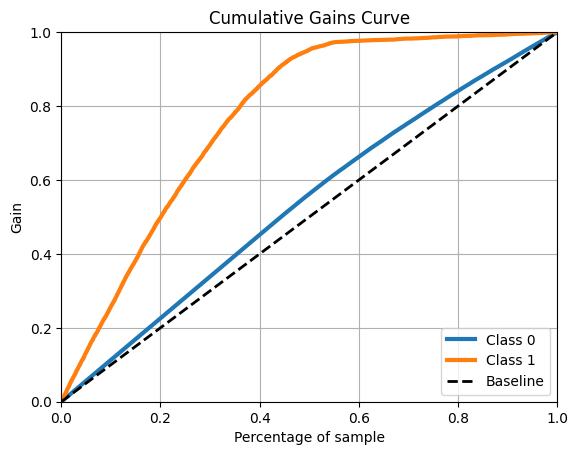

In [ ]:
#Accumulated gain

skplt.metrics.plot_cumulative_gain (y_test, y_hat_et);

#8.0 Model Performance

In [ ]:
df8 = X_test_.copy()
df8['response'] = y_test.copy()

In [ ]:
#propensity score - prediction (it is used to oerdanate the data)
df8['propensity score'] = y_hat[:,1].tolist()

#sorting clients by propensity score
df8 = df8.sort_values('propensity score', ascending=False).reset_index()

In [ ]:
def precision_at_k(data, k):
  #sorting clients by propensity score
  data = data.reset_index(drop=True)

  #creating ranking
  data['ranking'] = data.index +1

  #creating precision column
  data['precision_at_k'] = data['response'].cumsum()/data['ranking']

  return data.loc[k, 'precision_at_k']

In [ ]:
def recall_at_k(data, k):
  #sorting clients by propensity score
  data = data.reset_index(drop=True)

  #creating ranking
  data['ranking'] = data.index +1

  #creating precision column
  data['recall_at_k'] = data['response'].cumsum()/data['response'].sum()

  return data.loc[k, 'recall_at_k']

In [ ]:
#creating ranking
df8['ranking'] = df8.index +1

#creating precision column
df8['precision_at_k'] = df8['response'].cumsum()/df8['ranking']

In [ ]:
df8.head()

,index,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response,propensity score,ranking,precision_at_k
0,58043,58044,0.104592,0.200000,1,0.187561,0,0,1,0.359513,0.193718,0.138408,1,1.0,1,1.000000
1,229055,229056,0.104592,0.246154,1,0.102692,0,1,1,-1.618731,0.017475,0.221453,0,1.0,2,0.500000
2,279644,279645,0.104592,0.169231,1,0.123664,0,0,1,-0.121455,0.193718,0.643599,0,1.0,3,0.333333
3,337350,337351,0.138543,0.769231,1,0.187561,0,0,1,1.540506,0.003290,0.387543,1,1.0,4,0.500000
4,2489,2490,0.104592,0.600000,1,0.083405,0,0,1,0.847255,0.353305,0.311419,0,1.0,5,0.400000


In [ ]:
df8.loc[50,'precision_at_k']

0.4117647058823529

In [ ]:
precision_at_50 = precision_at_k(df8,k=50)
precision_at_50

0.4117647058823529

In [ ]:
recall_at_50 = recall_at_k(df8,k=50)
recall_at_50

0.002277163305139883

#9.0 Health Insurance Class

In [ ]:
import pickle
import inflection
import math
import numpy as np
import pandas as pd
import datetime


class HealthInsurance( object ):
  def __init__( self ):
    self.home_path = ''
    self.annual_premium_standart              = pickle.load( open( self.home_path + 'annual_premium.pkl', 'rb') )
    self.age_scaler                           = pickle.load( open( self.home_path + 'age.pkl', 'rb') )
    self.vintage_scaler                       = pickle.load( open( self.home_path + 'vintage.pkl', 'rb') )

  def clean_data (self, df1):

  old_columns = ['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
              'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
              'Policy_Sales_Channel', 'Vintage', 'Response']

  snakecase = lambda x: inflection.underscore(x)
  new_columns = list(map(self.snakecase, old_columns))

  df1.columns = new_columns

  return df1


  def data_preparation(self, df5):

  #standardization
  df5['annual_premium'] = self.stand_annual_premium.fit_transform(df5[['annual_premium']].values)

  #recasling
  df5['age'] = self.age_scaler.fit_transform(df5[['age']].values)
  df5['vintage'] = self.vintage_scaler.fit_transform(df5[['vintage']].values)

  #vehicle_damage (Label encoding)
  df5['vehicle_damage'] = df5['vehicle_damage'].apply(lambda x: 1 if x == "Yes" else 0)

  #gender (Label encoding)
  mean_encoded_gender = df5.groupby('gender')['response'].mean()
  df5['gender'] = df5['gender'].map(self.mean_encoded_gender)

  #vehicle age transformation (Order encoding)
  df5['vehicle_age'] = df5['vehicle_age'].apply(lambda x: 0 if x == "< 1 Year" else 1 if x== "1-2 Year" else 2)

  #region_code (Targeting encoding - multivariables)
  mean_encoded_region = df5.groupby('region_code')['response'].mean()
  df5['region_code'] = df5['region_code'].map(self.mean_encoded_region)

  #previously insurance (Label encoding)
  df5['previously_insured'] = df5['previously_insured'].apply(lambda x: 1 if x == "Yes" else 0)

  #policy sales channel (Targeting encoding - multivariables)
  mean_encoded_channel = df5.groupby('policy_sales_channel').size()/len(df5)
  df5['policy_sales_channel'] = df5['policy_sales_channel'].map(self.mean_encoded_channel)

  #feature selection
  cols_selected = ['vintage','annual_premium','age', 'vehicle_damage', 'region_code', 'policy_sales_channel', 'vehicle_age']

  return df5[cols_selected]

  def get_prediction( self, model, original_data, test_data ):
    #prediction
    pred = model.predict_proba( test_data )

    #join pred into the original data
    original_data['prediction'] = pred

    return original_data.to_json( orient='records', date_format='iso' )


#10. API HANDLER

In [ ]:
import os
import pickle
import pandas as pd
from flask import Flask, request, Response
from HealthInsurance import HealthInsurance

#loading model
with open('model/xgb_model_tunned.pkl', 'rb') as file:
  model = pickle.load(file)

app = Flask( __name__ )

@app.route( '/health_insurance/predict', methods=['POST'] )
def HealthInsurance_predict():
    test_json = request.get_json()
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0])
        else:
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys()) #multiple examples

        #instantiate HealthInsurance Class
        pipeline = HealthInsurance()

        #data cleaning
        df1 = pipeline.clean_data( test_raw )

        #feature enginnering
        df2 = pipeline.data_preparation( df1 )

        #prediction
        df_response = pipeline.get_prediction( model, test_raw, df2 )

        return df_response

    else:
      return Response( '{}', status=200, mimetype='application/json' )


if __name__ == '__main__':
    port = os.environ.get('PORT', 5000)
    app.run( host='0.0.0.0', port=port)

In [ ]:
!ls /content/

age.pkl  annual_premium.pkl  sample_data  train.csv  vintage.pkl


In [ ]:
#compact folder with all files
!zip -r /content/health_insurance_cross_sell_colab.zip /content/

  adding: content/ (stored 0%)
  adding: content/.config/ (stored 0%)
  adding: content/.config/.last_update_check.json (deflated 23%)
  adding: content/.config/hidden_gcloud_config_universe_descriptor_data_cache_configs.db (deflated 97%)
  adding: content/.config/default_configs.db (deflated 98%)
  adding: content/.config/config_sentinel (stored 0%)
  adding: content/.config/logs/ (stored 0%)
  adding: content/.config/logs/2024.12.17/ (stored 0%)
  adding: content/.config/logs/2024.12.17/14.20.51.759398.log (deflated 87%)
  adding: content/.config/logs/2024.12.17/14.20.54.155997.log (deflated 57%)
  adding: content/.config/logs/2024.12.17/14.20.17.888207.log (deflated 93%)
  adding: content/.config/logs/2024.12.17/14.21.04.307006.log (deflated 58%)
  adding: content/.config/logs/2024.12.17/14.21.04.951345.log (deflated 56%)
  adding: content/.config/logs/2024.12.17/14.20.40.843137.log (deflated 58%)
  adding: content/.config/active_config (stored 0%)
  adding: content/.config/.last_su

In [ ]:
#download .zip file
from google.colab import files
files.download('/content/health_insurance_cross_sell_colab.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
pip freeze > requirements.txt

In [1]:
import json
import pandas as pd
import requests


In [2]:
df = pd.read_csv('/content/train.csv')

In [3]:
#convert DataFrame in json
data = json.dumps( df.to_dict( orient='records' ) )

In [4]:
#API call
url = 'https://health-insurance-api-vxu4.onrender.com'
header = {'Content-type': 'application/json' }
data = data

r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

Status Code 502
